In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import poisson
from tqdm.auto import tqdm

Solve the hospital scheduling example with Q-learning.

Use the following parameters to generate interaction data (but note that the Q learning method does not use many of these parameters directly)

Clinic opens at 8am, and closes at 8pm
w = 30 (patient waiting cost, per patient per hour)
W = 300 (abandonment cost of not treating a patient)
wage = 500 per on-demand doctor per hour (there are 10 doctors already scheduled for each hour, and you can ignore their wage since that doesn't change the calculations)
Wait room capacity = 80 patients
Max on-demand doc = 10
Arrival process: poisson process with lambda = 17
The initial number of patient (x_1) is anywhere between 0 and 80. (Think of these patients as having arrived before 8am and been waiting)
Output four things: the optimal policy in a tabular format, in a heatmap format; the cost-to-go values in a tabular format, and a heatmap format.

## **Initialization**

In [ ]:
waiting_cost = 30
abandonment_cost = 300
wage = 500
capacity = 80
max_doctor = 10
pois_lambda = 17
total_hours =12


q_table = np.zeros((total_hours+1, capacity+1, max_doctor+1))*0   # T, S, A  initialize
q_table[-1, :, :] = -300 * np.arange(0,capacity+1)[:, np.newaxis] # initialize last timestep with abandonment cost
ACTION_SPACE = np.arange(0, max_doctor+1) # A


Text(0.5, 1.0, 'new patients distribution')

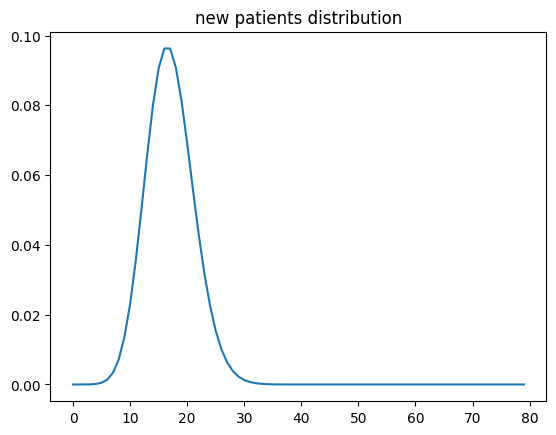

In [ ]:
probability= np.array([poisson.pmf(d, mu=17) for d in np.arange(0,80)])
ax = sns.lineplot(probability)
ax.set_title("new patients distribution")

## **Create Env**

In [ ]:
class env():
  def __init__(self):
    pass
  def reset(self):
    self.patient = np.random.randint(0,81)#min(np.random.poisson(lam=pois_lambda),80)
    self.time=0
    self.remaining_times = 12
    return self.patient, self.time

  def play(self, action):
    game_over = False
    doctor = 10 + action
    patient_untreated = max(self.patient- doctor * 2, 0) #calculate patient untreated
    self.time+=1 #advance time by 1
    self.remaining_times-=1
    if self.remaining_times ==0: #check if episodes over
      game_over= True
      reward = -(abandonment_cost * patient_untreated ) #abondonment cost of last period
    else:
      reward = -(waiting_cost * patient_untreated + wage * action) # waiting cost + doctor cost

    new_patient = np.random.poisson(lam=pois_lambda) #new patient
    self.patient = min(new_patient + patient_untreated, 80) # calculate toal patient
    # reward -= abandonment_cost* max((new_patient + patient_untreated-80),0) if not game_over else 0
    # print(self.patient)

    return reward, self.patient, self.time, game_over

In [ ]:
gamma = 0.9 #discount factor
patients = np.arange(0,81)
patients_prob = np.array([poisson.pmf(p, mu=pois_lambda) for p in patients])

## **Training Loop**

  0%|          | 0/600000 [00:00<?, ?it/s]

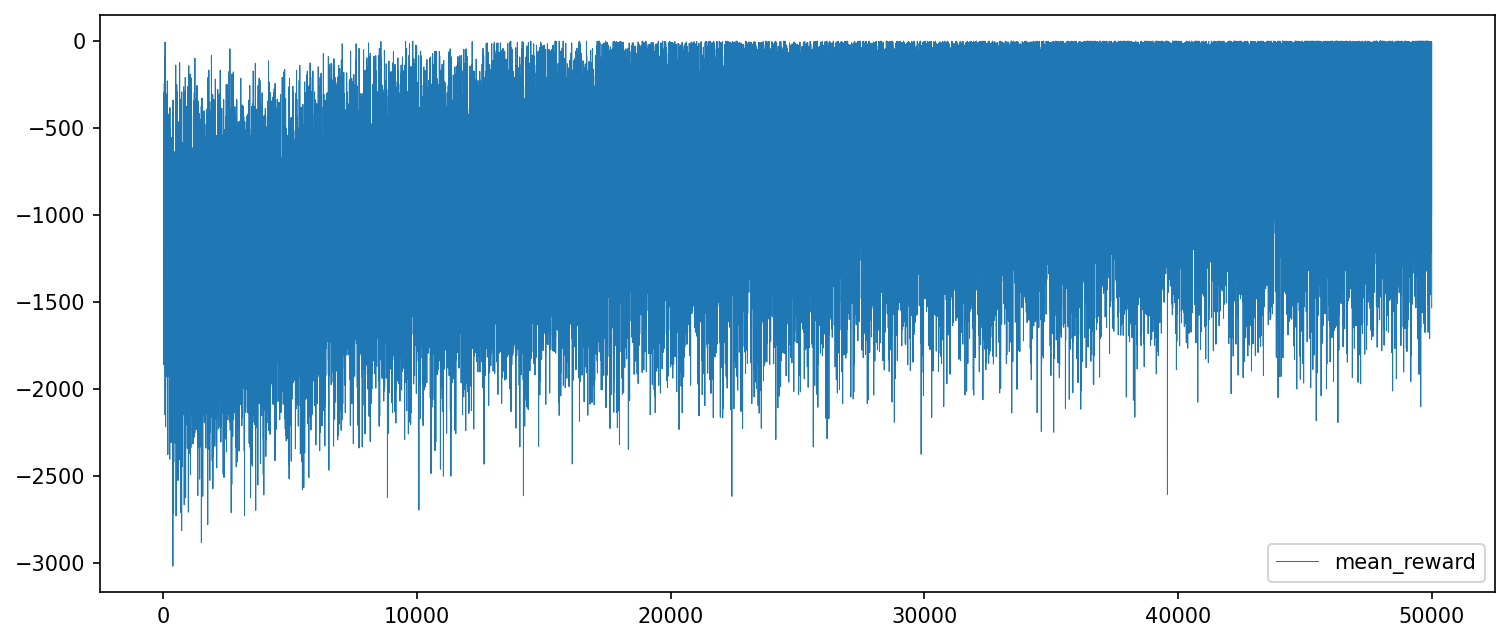

In [ ]:
total_steps = 50000 *12
epsilon = 0.3 # randomness
epsilon_scheduling = epsilon/total_steps # steps gets epsilon to zero
# epsilon_scheduling = 0.9985
lr = 0.15
game = env() #init game
patient, time = game.reset()
mean_reward_plot=[]
reward_counter =0
reward=0
for steps in tqdm(range(total_steps)):
  reward_counter += reward
  if np.random.rand(1)<=epsilon:
    action = np.random.randint(0, ACTION_SPACE.shape[0]) #random indices of action space
  else:
    action = np.argmax(q_table[time, patient, :]) #argmax indices
  epsilon -= epsilon_scheduling # reduce epslion
  epsilon = max(epsilon,0)

  reward, next_state, time, game_over = game.play(ACTION_SPACE[action]) #take action see result
  # print(time-1, patient, next_state, action)
  expected_cumulative_reward = np.max(q_table[time, next_state,:]) # the next state q value assume taking best action
  q_table[time-1, patient, action] = (1-lr)*q_table[time-1, patient, action] + lr*(reward + expected_cumulative_reward) #update q table
  patient = next_state #update state

  if game_over:
    patient, time = game.reset() #reset game
    mean_reward_plot.append(reward_counter/12) #mean reward during the game
    reward_counter =0


plt.figure(figsize=(12,5), dpi=150)
plt.plot(mean_reward_plot, linewidth =0.5, label = "mean_reward")
plt.legend()

## **Optimal policy**

(12, 81)


Text(0.5, 89.08333333333331, 'hours')

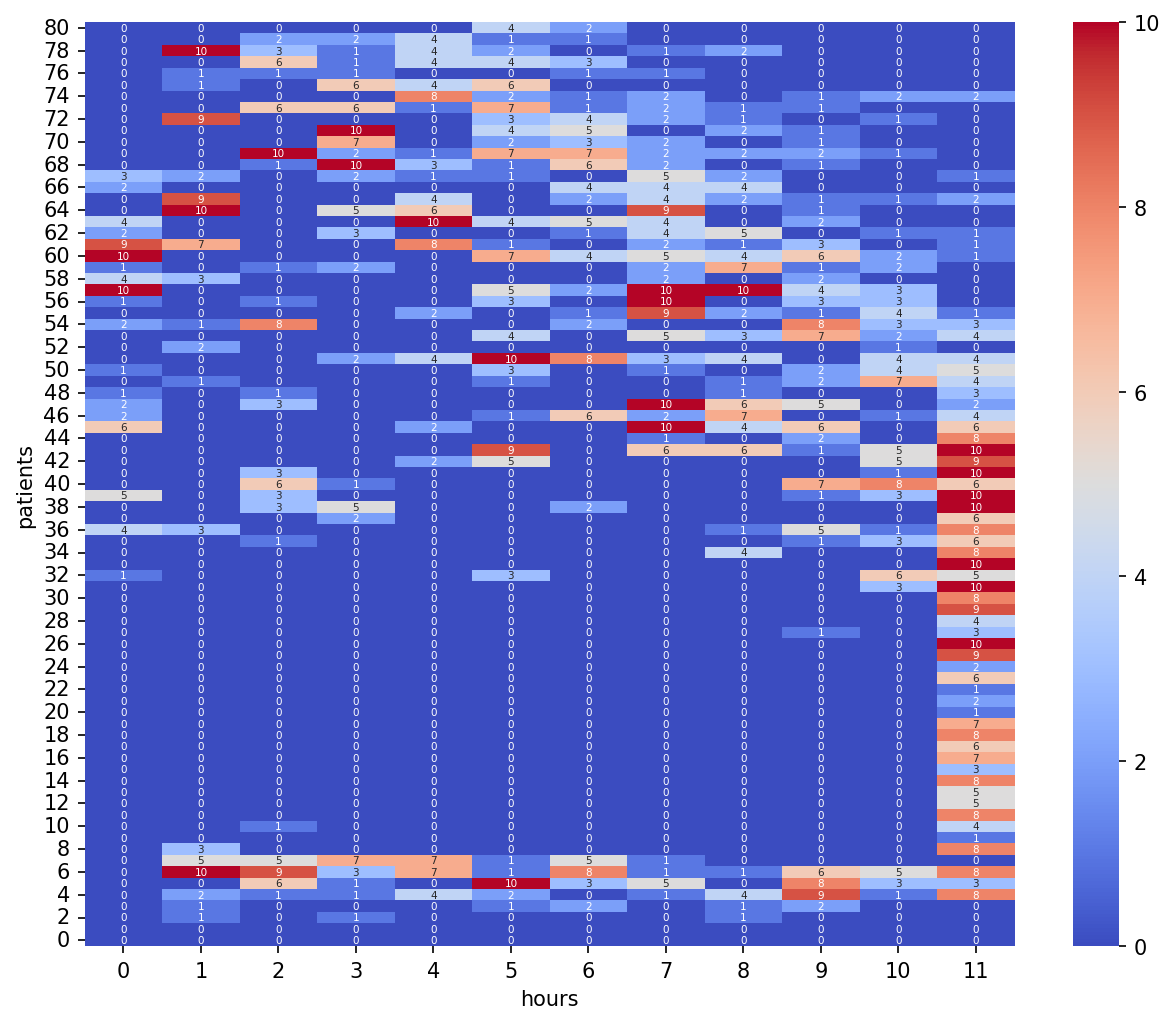

In [ ]:
plt.figure(figsize=(10,8), dpi=150)
optimal_policy = np.argmax(q_table[:-1,:], axis=-1) # T, S, A -> T, S
print(optimal_policy.shape)
fig=sns.heatmap(optimal_policy.T, cmap='coolwarm', annot=True, annot_kws={"fontsize":5} )
fig.invert_yaxis()
fig.set_ylabel("patients")
fig.set_xlabel("hours")

In [ ]:
pd.DataFrame(optimal_policy.T)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0
3,0,1,0,0,0,1,2,0,1,2,0,0
4,0,2,1,1,4,2,0,1,4,9,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,1,1,1,0,0,1,1,0,0,0,0
77,0,0,6,1,4,4,3,0,0,0,0,0
78,0,10,3,1,4,2,0,1,2,0,0,0
79,0,0,2,2,4,1,1,0,0,0,0,0


## **cost to go**

(12, 81)


Text(0.5, 89.08333333333331, 'hours')

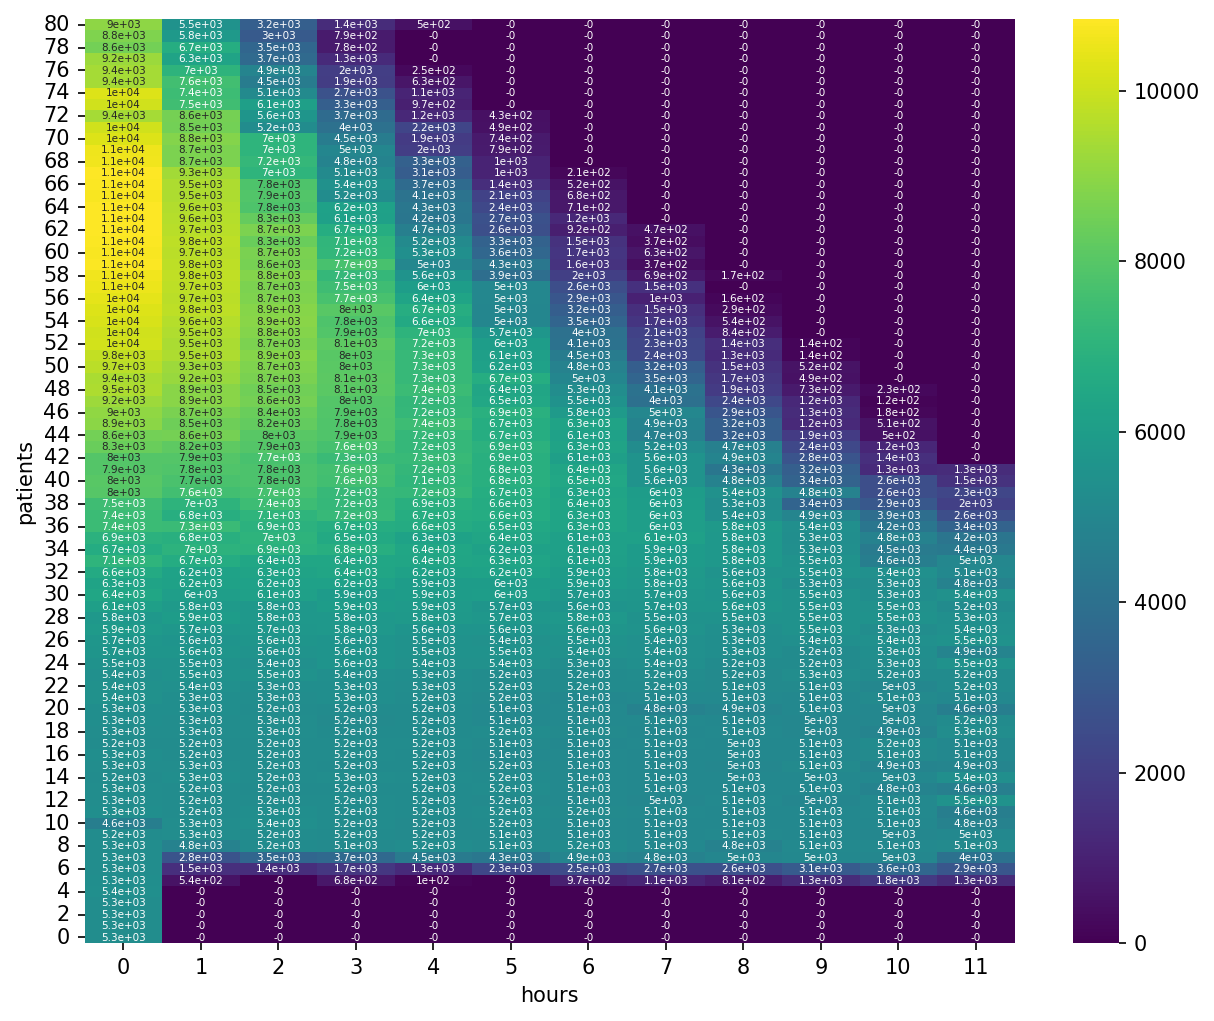

In [ ]:
plt.figure(figsize=(10,8), dpi=150)
cost_to_go = -np.max(q_table[:-1,:], axis=-1) # T, S, A -> T, S
print(cost_to_go.shape)
fig=sns.heatmap(cost_to_go.T, annot=True, annot_kws={"fontsize":5}, cmap='viridis')
fig.invert_yaxis()
fig.set_ylabel("patients")
fig.set_xlabel("hours")

In [ ]:
pd.DataFrame(cost_to_go.T)

,0,1,2,3,4,5,6,7,8,9,10,11
0,5288.426462,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,5269.329053,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,5275.756185,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,5288.574366,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,5366.521275,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,9374.180519,7011.819366,4892.593341,1978.254863,252.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
77,9215.494831,6294.406510,3722.294593,1298.967736,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
78,8553.069698,6708.702022,3533.873585,784.010815,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
79,8763.910270,5814.258861,3017.738265,792.300000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
